In [1]:
import pandas as pd, numpy as np, tensorflow as tf
from tensorflow.contrib import rnn

/Users/mengranwang/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Prepare data
* Input data as history records for the same patient, while train_target as future visit

In [83]:
input_data = pd.read_csv('data/lstm_input_train.csv')
print(input_data.shape)
input_data=input_data.select_dtypes(exclude=["object"])
print(input_data.shape)
train_target = pd.read_csv('data/lstm_output_train.csv')
print(train_target.shape)
train_target=train_target.select_dtypes(exclude=["object"])
print(train_target.shape)
train_target['Diag'] = np.argmax(train_target[['CN_Diag','MCI_Diag','AD_Diag']].values,axis=1)

(8433, 283)
(8433, 281)
(2435, 10)
(2435, 8)


In [84]:
val_target = pd.read_csv('data/lstm_output_val.csv')
print(val_target.shape)
val_target=val_target.select_dtypes(exclude=["object"])
print(val_target.shape)
val_target['Diag'] = np.argmax(val_target[['CN_Diag','MCI_Diag','AD_Diag']].values,axis=1)
val_target.head()

(848, 10)
(848, 8)


,PTID_Key,CN_Diag,MCI_Diag,AD_Diag,ADAS13,Ventricles_Norm,MMSE,Month,Diag
0,5,1.0,0.0,0.0,16.0,0.019279,28.0,72.0,0
1,5,0.5,0.5,0.0,19.5,0.019279,27.5,78.0,0
2,5,0.0,1.0,0.0,23.0,0.019279,27.0,85.0,1
3,5,0.0,0.5,0.5,26.0,0.019279,27.0,90.0,1
4,5,0.0,0.0,1.0,29.0,0.019279,27.0,97.0,2


In [85]:
input_data.head()
# input_data['EXAMDATE'].dtype

,0,1,2,3,4,5,6,7,8,9,...,271,272,273,274,275,276,277,PTID_Key,DX,Month
0,-0.914682,-0.601231,-1.025777,0.646176,1.011424,0.545620,0.413133,0.157729,0.240342,1.240933,...,0.881033,-0.162544,1.078744,1.362077,1.059333,0.267904,-0.928759,1.0,2,0.0
1,-0.551814,-0.979159,-1.117663,1.076771,0.625453,0.594147,0.200665,-0.109799,0.167253,1.085187,...,1.949152,-0.949106,-0.750425,0.614402,1.703636,-0.747710,-0.966335,1.0,2,4.0
2,-0.819792,-0.982411,-1.010481,1.050002,0.690168,0.794730,0.281609,-0.584068,0.522935,1.314278,...,0.429191,-0.094298,0.603369,0.183042,0.871928,0.794578,0.589846,1.0,2,9.0
3,-1.336588,0.124982,0.265170,0.702093,-0.806993,0.915643,-0.873193,0.532319,-1.443681,0.450639,...,1.360018,0.069672,0.544021,-1.105401,0.759985,1.659128,-0.180586,2.0,0,0.0
4,-1.562420,0.529299,0.027853,0.916200,-1.044956,1.685090,-0.881126,0.370308,-0.712720,-0.208872,...,0.207917,-0.230468,1.791909,-0.451569,1.189610,0.329250,-1.143252,2.0,0,6.0


In [86]:
train_target.head()

,PTID_Key,CN_Diag,MCI_Diag,AD_Diag,ADAS13,Ventricles_Norm,MMSE,Month,Diag
0,8,0.0,1.0,0.0,5.0,0.012128,30.0,18.0,1
1,8,0.0,1.0,0.0,5.0,0.012128,30.0,25.0,1
2,8,0.0,1.0,0.0,5.0,0.012128,30.0,31.0,1
3,18,0.0,1.0,0.0,9.0,0.020526,30.0,26.0,1
4,18,0.0,1.0,0.0,10.5,0.020526,29.5,32.0,1


In [87]:
def prep_data(train_target):
    # Put all the future dianosis, past visit measurements in list
    ID_train = np.unique(train_target.PTID_Key.values).tolist()
    pred_step = 8
    DX_num = 3
    data_rows_list=[]
    for ID in ID_train:
        # Put the values for 'DX' of each patient in a list
    #     print(ID)
        dx = train_target[train_target['PTID_Key']==ID]['Diag'].values
        adas13 = train_target[train_target['PTID_Key']==ID]['ADAS13'].values
        ventricles = train_target[train_target['PTID_Key']==ID]['Ventricles_Norm'].values
        mmse = train_target[train_target['PTID_Key']==ID]['MMSE'].values
    #     print(dx)
        # Number of visit in train_target of each patient
        future_visit_times = len(train_target[train_target['PTID_Key']==ID]) 
        # Put all the values (each row and each column) of each patient except PTID and EXAMDATE in a 2d array
        records = input_data[input_data['PTID_Key']==ID].iloc[:,2:-1].values
        # number of visit in input_data of each patient
        past_visit_times = records.shape[0]    
        data_rows_list.append({'PTID': ID, 'Diag': dx, 'ADAS13': adas13, 'Ventricles_Norm': ventricles, 'MMSE': mmse,
                   'HistoryRecords': records, 'PastVisit': past_visit_times, 'FutureVisit': future_visit_times})

    df = pd.DataFrame(data_rows_list)

    cols = ['PTID', 'Diag', 'HistoryRecords', 'PastVisit', 'FutureVisit']
    cols_adas13=['PTID', 'ADAS13', 'HistoryRecords', 'PastVisit', 'FutureVisit']
    cols_ventricles=['PTID', 'Ventricles_Norm', 'HistoryRecords', 'PastVisit', 'FutureVisit']
    cols_mmse=['PTID', 'MMSE', 'HistoryRecords', 'PastVisit', 'FutureVisit']
    df_diag = df[cols]
    df_adas13=df[cols_adas13]
    df_ventricles=df[cols_ventricles]
    df_mmse=df[cols_mmse]
    df_mmse.head()
    
    return df_diag,df_adas13,df_ventricles, df_mmse

In [88]:
train_diag,train_adas13,train_ventricles, train_mmse=prep_data(train_target)

In [98]:
val_diag,val_adas13,val_ventricles, val_mmse=prep_data(val_target)
val_diag.head()

KeyboardInterrupt: 

In [99]:
train_diag.head()

,PTID,Diag,HistoryRecords,PastVisit,FutureVisit
0,8,"[1, 1, 1]","[[-3.109950346394504, 1.7659272528930925, -1.1...",3,3
1,18,"[1, 1, 1, 1, 1]","[[-0.14840633456671898, 0.18691355216250946, 0...",4,5
2,21,"[1, 1, 1, 1, 1, 1, 1, 1]","[[0.09863400629845356, -0.015008111637147197, ...",1,8
3,22,"[1, 1, 1, 1, 1, 1, 1, 1]","[[-0.321097623580549, 0.1842053769217176, 0.31...",1,8
4,25,"[1, 2]","[[0.04354647548381548, 1.2287593833508572, 0.9...",1,2


In [41]:
records.shape[1]

278

In [42]:
df.PastVisit.describe()

count    475.00000
mean       2.92000
std        3.10266
min        1.00000
25%        1.00000
50%        2.00000
75%        3.00000
max       15.00000
Name: PastVisit, dtype: float64

In [43]:
df.FutureVisit.describe()

count    475.000000
mean       5.126316
std        2.072739
min        1.000000
25%        4.000000
50%        6.000000
75%        7.000000
max        9.000000
Name: FutureVisit, dtype: float64

In [44]:
# # Shuffle dataframe with random_state set to make sure every time it splits the same training and test datasets
# from sklearn.model_selection import train_test_split
# train, test = train_test_split(df, test_size=0.2, random_state=0)
# train.head()

,PTID,Diag,HistoryRecords,PastVisit,FutureVisit
363,1308,"[0, 0, 0, 0, 0, 0, 0]","[[-0.5769772984480899, 1.017995339437021, 3.91...",4,7
196,739,"[0, 0]","[[-2.15517666683936, 1.3631062857287908, 2.006...",1,2
124,478,"[0, 0, 0, 0, 0, 0]","[[-3.1196540056971567, 0.6791391919952742, 6.3...",1,6
263,968,"[2, 2, 2, 2, 2, 2]","[[1.8013340588466924, 1.68619485868166, 0.9421...",3,6
59,236,"[1, 1, 1, 1, 1, 1, 1, 1]","[[-6.3227085221548425, 0.6803271656856413, 0.4...",3,8


### Shuffle and sampling each mini-batch
*  Create an iterator for enumerating the elements in the dataset

In [91]:
class PaddedDataIterator():
    # Instantiate the class with initial state. 
    def __init__(self, df):
        self.df = df
        self.size = len(self.df)
        self.epochs = 0
        self.shuffle()
    def shuffle(self):
        self.df = self.df.sample(frac=1).reset_index(drop=True)
        self.cursor = 0
    def next_batch(self, batch_size, feature_num = records.shape[1], pred_step = 8):
        # If reach the last batch of this epoch, so start the next epoch with epoch++1, 
        # cursor back to 0 and shuffle the whole dataset
        if self.cursor+batch_size > self.size: # last batch
            self.epochs += 1
            self.shuffle()            
        res = self.df.loc[self.cursor:self.cursor+batch_size-1] # get the dataset of this batch
        self.cursor += batch_size # move the cursor to the beginning of next batch
        
        # Pad sequences with 0s so they are all the same Length in past visit data 
        # and pad sequences the same as last known 'Diag' value in future visit data
        maxlen = max(res['PastVisit']) # get the maximum pastVisit sequence length
        x = np.zeros([batch_size, maxlen, feature_num], dtype=np.float) # create same length tensor eg 256x15x15
        for i, x_i in enumerate(x):
            # x_i=15x15, fill the first few elements with existed pastVisit records, the rest will remain 0
            x_i[:res['PastVisit'].values[i]] = res['HistoryRecords'].values[i]
                
        labels = np.ones([batch_size, pred_step], dtype=np.int) 
        # eg 256x8 patient in each row and ith visit in each column
        for i in range(batch_size):
            # Get the last element of 'Diag' value of each patient, and make all elements in labels same as this last value
            labels[i,:] = labels[i,:] * res['Diag'].values[i][-1] 
            # Fill the first few elements with existed futureVisit 'Diag' value, the rest remain the same as the last known value
            labels[i,:res['FutureVisit'].values[i]] = res['Diag'].values[i][:min(pred_step,res['FutureVisit'].values[i])]
            
        # x is all the past test results history of each patient, eg 256x15x12, test result X visit
        # label is the 'Diag" value of every future visit of each patient eg 256x8, 
        # res['PastVisit'] is the past visit time eg 256
        return x, labels, res['PastVisit']

In [48]:
data = PaddedDataIterator(train)
d = data.next_batch(256)
print("Past test history:", d[0].shape)
print("future visit results:", d[1].shape)
print("past visit times:", d[2].shape)

Past test history: (256, 15, 278)
future visit results: (256, 8)
past visit times: (256,)


In [95]:
def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()

def build_graph(
    num_layers=3,
    feature_size = records.shape[1],
    state_size = 64,
    batch_size = 64,
    pred_times = 8,
    num_classes = 3):

    reset_graph()

    # Placeholders
    x = tf.placeholder('float', [batch_size, None, feature_size]) # input: shape=(batch_size,time_steps,feature_size)
    seqlen = tf.placeholder(tf.int32, [batch_size])
    y = tf.placeholder(tf.int32, [batch_size, pred_times]) 
    keep_prob = tf.placeholder(tf.float32,[])

    # RNN single cell
    cell = tf.nn.rnn_cell.GRUCell(state_size)
     
    # Run dynamic_rnn to get all the output sequences
    # init_state: shape= (batch_size,cell.state_size) with all 0
    init_state = tf.get_variable('init_state', [1, state_size],
                                 initializer=tf.constant_initializer(0.0))
    init_state = tf.tile(init_state, [batch_size, 1])
    rnn_outputs, final_state = tf.nn.dynamic_rnn(cell, inputs=x, sequence_length=seqlen,
                                                 initial_state=init_state) 
    # rnn_output: shape=((batch_size, time_steps, cell.output_size))

    # Add dropout, as the model otherwise quickly overfits
    rnn_outputs = tf.nn.dropout(rnn_outputs, keep_prob)
    
    # Get the output
    # Reshape rnn_outputs to a 2d tensor for softmax processing
    idx = tf.range(batch_size)*tf.shape(rnn_outputs)[1] + (seqlen - 1)
    last_rnn_output = tf.gather(tf.reshape(rnn_outputs, [-1, state_size]), idx)
    
    W_nn = tf.get_variable('W_nn', [state_size, state_size])
    b_nn = tf.get_variable('b_nn', [state_size], initializer=tf.constant_initializer(0.0))
    nn_output = tf.tanh(tf.matmul(last_rnn_output, W_nn) + b_nn)
    
    # Connect reshaped rnn_output to softmax layer
    with tf.variable_scope('softmax'):
        W = tf.get_variable('W', [state_size, pred_times, num_classes])
        b = tf.get_variable('b', [pred_times, num_classes], initializer=tf.constant_initializer(0.0))
    logits = tf.tensordot(nn_output, W, [[1],[0]]) + b
    preds = tf.nn.softmax(logits) # get probability distribution from softmax 
    
    correct = tf.equal(tf.cast(tf.argmax(preds,2), dtype=tf.int32), y)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits, labels = y))
    train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

    return {
        'x': x,
        'seqlen': seqlen,
        'y': y,
        'dropout': keep_prob,
        'loss': loss,
        'ts': train_step,
        'preds': preds,
        'accuracy': accuracy
    }

In [96]:
def train_graph(graph, num_epochs, batch_size = 64, iterator = PaddedDataIterator):
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        # Initialize all the variables 
        init.run()
        tr = iterator(train_diag)
        te = iterator(val_diag)

        step, accuracy = 0, 0
        tr_losses, te_losses = [], []
        current_epoch = 0
        while current_epoch < num_epochs:
            step += 1
            batch = tr.next_batch(batch_size)
            feed = {g['x']: batch[0], g['y']: batch[1], g['seqlen']: batch[2], g['dropout']: 0.6}
            accuracy_, _ = sess.run([g['accuracy'], g['ts']], feed_dict=feed)
            accuracy += accuracy_

            if tr.epochs > current_epoch:
                current_epoch += 1
                tr_losses.append(accuracy / step)
                step, accuracy = 0, 0

                #eval test set
                te_epoch = te.epochs
                while te.epochs == te_epoch:
                    step += 1
                    batch = te.next_batch(batch_size)
                    feed = {g['x']: batch[0], g['y']: batch[1], g['seqlen']: batch[2], g['dropout']: 1.0}
                    accuracy_ = sess.run([g['accuracy']], feed_dict=feed)[0]
                    accuracy += accuracy_

                te_losses.append(accuracy / step)
                step, accuracy = 0,0
                print("Accuracy after epoch", current_epoch, " - training error:", tr_losses[-1], "- test error:", te_losses[-1])
    return tr_losses, te_losses

In [97]:

num_epochs=4000
g = build_graph()

tr_losses, te_losses = train_graph(g,num_epochs)


/Users/mengranwang/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Accuracy after epoch 1  - training error: 0.341064453125 - test error: 0.3671875
Accuracy after epoch 2  - training error: 0.33900669642857145 - test error: 0.359375
Accuracy after epoch 3  - training error: 0.35658482142857145 - test error: 0.365234375
Accuracy after epoch 4  - training error: 0.3462611607142857 - test error: 0.361328125
Accuracy after epoch 5  - training error: 0.34598214285714285 - test error: 0.357421875
Accuracy after epoch 6  - training error: 0.36551339285714285 - test error: 0.3623046875
Accuracy after epoch 7  - training error: 0.36104910714285715 - test error: 0.3701171875
Accuracy after epoch 8  - training error: 0.36495535714285715 - test error: 0.3798828125
Accuracy after epoch 9  - training error: 0.36551339285714285 - test error: 0.369140625
Accuracy after epoch 10  - training error: 0.3515625 - test error: 0.349609375
Accuracy after epoch 11  - training error: 0.3724888392857143 - test error: 0.3564453125
Accuracy after epoch 12  - training error: 0.380

Accuracy after epoch 95  - training error: 0.6004464285714286 - test error: 0.5068359375
Accuracy after epoch 96  - training error: 0.6130022321428571 - test error: 0.5673828125
Accuracy after epoch 97  - training error: 0.572265625 - test error: 0.564453125
Accuracy after epoch 98  - training error: 0.6196986607142857 - test error: 0.470703125
Accuracy after epoch 99  - training error: 0.5954241071428571 - test error: 0.5712890625
Accuracy after epoch 100  - training error: 0.6141183035714286 - test error: 0.5478515625
Accuracy after epoch 101  - training error: 0.6219308035714286 - test error: 0.5439453125
Accuracy after epoch 102  - training error: 0.6199776785714286 - test error: 0.53515625
Accuracy after epoch 103  - training error: 0.6065848214285714 - test error: 0.525390625
Accuracy after epoch 104  - training error: 0.6397879464285714 - test error: 0.576171875
Accuracy after epoch 105  - training error: 0.626953125 - test error: 0.5419921875
Accuracy after epoch 106  - trainin

Accuracy after epoch 189  - training error: 0.8588169642857143 - test error: 0.578125
Accuracy after epoch 190  - training error: 0.8434709821428571 - test error: 0.65625
Accuracy after epoch 191  - training error: 0.8775111607142857 - test error: 0.6015625
Accuracy after epoch 192  - training error: 0.8590959821428571 - test error: 0.6494140625
Accuracy after epoch 193  - training error: 0.8537946428571429 - test error: 0.6044921875
Accuracy after epoch 194  - training error: 0.8825334821428571 - test error: 0.6220703125
Accuracy after epoch 195  - training error: 0.8537946428571429 - test error: 0.630859375
Accuracy after epoch 196  - training error: 0.8897879464285714 - test error: 0.5986328125
Accuracy after epoch 197  - training error: 0.8736049107142857 - test error: 0.6328125
Accuracy after epoch 198  - training error: 0.8688616071428571 - test error: 0.6416015625
Accuracy after epoch 199  - training error: 0.8724888392857143 - test error: 0.5830078125
Accuracy after epoch 200  

Accuracy after epoch 283  - training error: 0.9436383928571429 - test error: 0.681640625
Accuracy after epoch 284  - training error: 0.9411272321428571 - test error: 0.677734375
Accuracy after epoch 285  - training error: 0.9430803571428571 - test error: 0.6513671875
Accuracy after epoch 286  - training error: 0.9497767857142857 - test error: 0.6484375
Accuracy after epoch 287  - training error: 0.9447544642857143 - test error: 0.6884765625
Accuracy after epoch 288  - training error: 0.9450334821428571 - test error: 0.65625
Accuracy after epoch 289  - training error: 0.9416852678571429 - test error: 0.615234375
Accuracy after epoch 290  - training error: 0.9439174107142857 - test error: 0.671875
Accuracy after epoch 291  - training error: 0.9358258928571429 - test error: 0.6083984375
Accuracy after epoch 292  - training error: 0.9478236607142857 - test error: 0.701171875
Accuracy after epoch 293  - training error: 0.9461495535714286 - test error: 0.6650390625
Accuracy after epoch 294  

Accuracy after epoch 377  - training error: 0.9561941964285714 - test error: 0.6318359375
Accuracy after epoch 378  - training error: 0.9676339285714286 - test error: 0.5888671875
Accuracy after epoch 379  - training error: 0.9592633928571429 - test error: 0.623046875
Accuracy after epoch 380  - training error: 0.953125 - test error: 0.6826171875
Accuracy after epoch 381  - training error: 0.9567522321428571 - test error: 0.6181640625
Accuracy after epoch 382  - training error: 0.9536830357142857 - test error: 0.6005859375
Accuracy after epoch 383  - training error: 0.9547991071428571 - test error: 0.6728515625
Accuracy after epoch 384  - training error: 0.9520089285714286 - test error: 0.7119140625
Accuracy after epoch 385  - training error: 0.9626116071428571 - test error: 0.634765625
Accuracy after epoch 386  - training error: 0.9578683035714286 - test error: 0.6318359375
Accuracy after epoch 387  - training error: 0.9545200892857143 - test error: 0.619140625
Accuracy after epoch 38

Accuracy after epoch 471  - training error: 0.9704241071428571 - test error: 0.6552734375
Accuracy after epoch 472  - training error: 0.9595424107142857 - test error: 0.6708984375
Accuracy after epoch 473  - training error: 0.9612165178571429 - test error: 0.6416015625
Accuracy after epoch 474  - training error: 0.9612165178571429 - test error: 0.623046875
Accuracy after epoch 475  - training error: 0.9612165178571429 - test error: 0.6669921875
Accuracy after epoch 476  - training error: 0.9614955357142857 - test error: 0.619140625
Accuracy after epoch 477  - training error: 0.9561941964285714 - test error: 0.6650390625
Accuracy after epoch 478  - training error: 0.9698660714285714 - test error: 0.630859375
Accuracy after epoch 479  - training error: 0.9614955357142857 - test error: 0.619140625
Accuracy after epoch 480  - training error: 0.9679129464285714 - test error: 0.6865234375
Accuracy after epoch 481  - training error: 0.9701450892857143 - test error: 0.6044921875
Accuracy after

Accuracy after epoch 564  - training error: 0.9662388392857143 - test error: 0.662109375
Accuracy after epoch 565  - training error: 0.9723772321428571 - test error: 0.6318359375
Accuracy after epoch 566  - training error: 0.97265625 - test error: 0.689453125
Accuracy after epoch 567  - training error: 0.9698660714285714 - test error: 0.6611328125
Accuracy after epoch 568  - training error: 0.9679129464285714 - test error: 0.6328125
Accuracy after epoch 569  - training error: 0.9709821428571429 - test error: 0.673828125
Accuracy after epoch 570  - training error: 0.9693080357142857 - test error: 0.638671875
Accuracy after epoch 571  - training error: 0.9640066964285714 - test error: 0.703125
Accuracy after epoch 572  - training error: 0.9720982142857143 - test error: 0.7060546875
Accuracy after epoch 573  - training error: 0.9642857142857143 - test error: 0.6845703125
Accuracy after epoch 574  - training error: 0.9670758928571429 - test error: 0.6708984375
Accuracy after epoch 575  - t

Accuracy after epoch 658  - training error: 0.9765625 - test error: 0.70703125
Accuracy after epoch 659  - training error: 0.9732142857142857 - test error: 0.689453125
Accuracy after epoch 660  - training error: 0.9693080357142857 - test error: 0.6826171875
Accuracy after epoch 661  - training error: 0.9748883928571429 - test error: 0.6630859375
Accuracy after epoch 662  - training error: 0.9676339285714286 - test error: 0.681640625
Accuracy after epoch 663  - training error: 0.9760044642857143 - test error: 0.625
Accuracy after epoch 664  - training error: 0.97265625 - test error: 0.6884765625
Accuracy after epoch 665  - training error: 0.9709821428571429 - test error: 0.6494140625
Accuracy after epoch 666  - training error: 0.966796875 - test error: 0.6513671875
Accuracy after epoch 667  - training error: 0.9718191964285714 - test error: 0.6484375
Accuracy after epoch 668  - training error: 0.9704241071428571 - test error: 0.7294921875
Accuracy after epoch 669  - training error: 0.97

Accuracy after epoch 752  - training error: 0.9765625 - test error: 0.6552734375
Accuracy after epoch 753  - training error: 0.9734933035714286 - test error: 0.6806640625
Accuracy after epoch 754  - training error: 0.9732142857142857 - test error: 0.6318359375
Accuracy after epoch 755  - training error: 0.97265625 - test error: 0.6396484375
Accuracy after epoch 756  - training error: 0.9762834821428571 - test error: 0.72265625
Accuracy after epoch 757  - training error: 0.9793526785714286 - test error: 0.625
Accuracy after epoch 758  - training error: 0.9684709821428571 - test error: 0.7021484375
Accuracy after epoch 759  - training error: 0.9793526785714286 - test error: 0.7109375
Accuracy after epoch 760  - training error: 0.974609375 - test error: 0.6748046875
Accuracy after epoch 761  - training error: 0.9790736607142857 - test error: 0.693359375
Accuracy after epoch 762  - training error: 0.9740513392857143 - test error: 0.646484375
Accuracy after epoch 763  - training error: 0.97

Accuracy after epoch 846  - training error: 0.9771205357142857 - test error: 0.6845703125
Accuracy after epoch 847  - training error: 0.9838169642857143 - test error: 0.6923828125
Accuracy after epoch 848  - training error: 0.9748883928571429 - test error: 0.6796875
Accuracy after epoch 849  - training error: 0.9852120535714286 - test error: 0.7109375
Accuracy after epoch 850  - training error: 0.9762834821428571 - test error: 0.650390625
Accuracy after epoch 851  - training error: 0.9740513392857143 - test error: 0.703125
Accuracy after epoch 852  - training error: 0.9810267857142857 - test error: 0.68359375
Accuracy after epoch 853  - training error: 0.9762834821428571 - test error: 0.671875
Accuracy after epoch 854  - training error: 0.9782366071428571 - test error: 0.6630859375
Accuracy after epoch 855  - training error: 0.9771205357142857 - test error: 0.7138671875
Accuracy after epoch 856  - training error: 0.982421875 - test error: 0.6357421875
Accuracy after epoch 857  - traini

Accuracy after epoch 940  - training error: 0.978515625 - test error: 0.6640625
Accuracy after epoch 941  - training error: 0.9866071428571429 - test error: 0.673828125
Accuracy after epoch 942  - training error: 0.9860491071428571 - test error: 0.6884765625
Accuracy after epoch 943  - training error: 0.9787946428571429 - test error: 0.681640625
Accuracy after epoch 944  - training error: 0.9852120535714286 - test error: 0.7001953125
Accuracy after epoch 945  - training error: 0.9866071428571429 - test error: 0.625
Accuracy after epoch 946  - training error: 0.9813058035714286 - test error: 0.6591796875
Accuracy after epoch 947  - training error: 0.978515625 - test error: 0.73046875
Accuracy after epoch 948  - training error: 0.9827008928571429 - test error: 0.6337890625
Accuracy after epoch 949  - training error: 0.9827008928571429 - test error: 0.6650390625
Accuracy after epoch 950  - training error: 0.9827008928571429 - test error: 0.7197265625
Accuracy after epoch 951  - training e

Accuracy after epoch 1033  - training error: 0.9810267857142857 - test error: 0.6708984375
Accuracy after epoch 1034  - training error: 0.9871651785714286 - test error: 0.689453125
Accuracy after epoch 1035  - training error: 0.9860491071428571 - test error: 0.6748046875
Accuracy after epoch 1036  - training error: 0.9801897321428571 - test error: 0.658203125
Accuracy after epoch 1037  - training error: 0.9815848214285714 - test error: 0.666015625
Accuracy after epoch 1038  - training error: 0.9857700892857143 - test error: 0.705078125
Accuracy after epoch 1039  - training error: 0.9874441964285714 - test error: 0.677734375
Accuracy after epoch 1040  - training error: 0.9835379464285714 - test error: 0.62890625
Accuracy after epoch 1041  - training error: 0.9827008928571429 - test error: 0.666015625
Accuracy after epoch 1042  - training error: 0.9896763392857143 - test error: 0.681640625
Accuracy after epoch 1043  - training error: 0.9854910714285714 - test error: 0.658203125
Accuracy 

Accuracy after epoch 1125  - training error: 0.9801897321428571 - test error: 0.681640625
Accuracy after epoch 1126  - training error: 0.9885602678571429 - test error: 0.6552734375
Accuracy after epoch 1127  - training error: 0.9829799107142857 - test error: 0.6982421875
Accuracy after epoch 1128  - training error: 0.9854910714285714 - test error: 0.689453125
Accuracy after epoch 1129  - training error: 0.9910714285714286 - test error: 0.669921875
Accuracy after epoch 1130  - training error: 0.9885602678571429 - test error: 0.6513671875
Accuracy after epoch 1131  - training error: 0.98828125 - test error: 0.6435546875
Accuracy after epoch 1132  - training error: 0.9849330357142857 - test error: 0.677734375
Accuracy after epoch 1133  - training error: 0.98046875 - test error: 0.6884765625
Accuracy after epoch 1134  - training error: 0.9896763392857143 - test error: 0.6787109375
Accuracy after epoch 1135  - training error: 0.9860491071428571 - test error: 0.65625
Accuracy after epoch 113

Accuracy after epoch 1218  - training error: 0.9860491071428571 - test error: 0.62109375
Accuracy after epoch 1219  - training error: 0.9874441964285714 - test error: 0.724609375
Accuracy after epoch 1220  - training error: 0.9905133928571429 - test error: 0.6552734375
Accuracy after epoch 1221  - training error: 0.9893973214285714 - test error: 0.6728515625
Accuracy after epoch 1222  - training error: 0.9854910714285714 - test error: 0.7021484375
Accuracy after epoch 1223  - training error: 0.9877232142857143 - test error: 0.65625
Accuracy after epoch 1224  - training error: 0.9860491071428571 - test error: 0.701171875
Accuracy after epoch 1225  - training error: 0.990234375 - test error: 0.677734375
Accuracy after epoch 1226  - training error: 0.9871651785714286 - test error: 0.646484375
Accuracy after epoch 1227  - training error: 0.9907924107142857 - test error: 0.662109375
Accuracy after epoch 1228  - training error: 0.9857700892857143 - test error: 0.716796875
Accuracy after epoc

Accuracy after epoch 1310  - training error: 0.9905133928571429 - test error: 0.6669921875
Accuracy after epoch 1311  - training error: 0.9896763392857143 - test error: 0.677734375
Accuracy after epoch 1312  - training error: 0.9896763392857143 - test error: 0.7333984375
Accuracy after epoch 1313  - training error: 0.9874441964285714 - test error: 0.642578125
Accuracy after epoch 1314  - training error: 0.9910714285714286 - test error: 0.6953125
Accuracy after epoch 1315  - training error: 0.9885602678571429 - test error: 0.6376953125
Accuracy after epoch 1316  - training error: 0.9891183035714286 - test error: 0.6953125
Accuracy after epoch 1317  - training error: 0.9899553571428571 - test error: 0.69921875
Accuracy after epoch 1318  - training error: 0.9854910714285714 - test error: 0.63671875
Accuracy after epoch 1319  - training error: 0.9893973214285714 - test error: 0.7041015625
Accuracy after epoch 1320  - training error: 0.990234375 - test error: 0.6923828125
Accuracy after epo

Accuracy after epoch 1403  - training error: 0.9893973214285714 - test error: 0.6396484375
Accuracy after epoch 1404  - training error: 0.990234375 - test error: 0.6904296875
Accuracy after epoch 1405  - training error: 0.9891183035714286 - test error: 0.697265625
Accuracy after epoch 1406  - training error: 0.9907924107142857 - test error: 0.6552734375
Accuracy after epoch 1407  - training error: 0.9899553571428571 - test error: 0.724609375
Accuracy after epoch 1408  - training error: 0.9933035714285714 - test error: 0.6748046875
Accuracy after epoch 1409  - training error: 0.9905133928571429 - test error: 0.6904296875
Accuracy after epoch 1410  - training error: 0.9927455357142857 - test error: 0.6669921875
Accuracy after epoch 1411  - training error: 0.9877232142857143 - test error: 0.71484375
Accuracy after epoch 1412  - training error: 0.9907924107142857 - test error: 0.66796875
Accuracy after epoch 1413  - training error: 0.9896763392857143 - test error: 0.6796875
Accuracy after 

Accuracy after epoch 1496  - training error: 0.9891183035714286 - test error: 0.6474609375
Accuracy after epoch 1497  - training error: 0.9919084821428571 - test error: 0.708984375
Accuracy after epoch 1498  - training error: 0.9935825892857143 - test error: 0.689453125
Accuracy after epoch 1499  - training error: 0.9891183035714286 - test error: 0.6572265625
Accuracy after epoch 1500  - training error: 0.9913504464285714 - test error: 0.67578125
Accuracy after epoch 1501  - training error: 0.9930245535714286 - test error: 0.6630859375
Accuracy after epoch 1502  - training error: 0.9891183035714286 - test error: 0.6767578125
Accuracy after epoch 1503  - training error: 0.9907924107142857 - test error: 0.6494140625
Accuracy after epoch 1504  - training error: 0.9924665178571429 - test error: 0.6708984375
Accuracy after epoch 1505  - training error: 0.9907924107142857 - test error: 0.681640625
Accuracy after epoch 1506  - training error: 0.9880022321428571 - test error: 0.64453125
Accura

Accuracy after epoch 1589  - training error: 0.9880022321428571 - test error: 0.642578125
Accuracy after epoch 1590  - training error: 0.9899553571428571 - test error: 0.734375
Accuracy after epoch 1591  - training error: 0.994140625 - test error: 0.6435546875
Accuracy after epoch 1592  - training error: 0.9927455357142857 - test error: 0.689453125
Accuracy after epoch 1593  - training error: 0.9933035714285714 - test error: 0.6689453125
Accuracy after epoch 1594  - training error: 0.9938616071428571 - test error: 0.673828125
Accuracy after epoch 1595  - training error: 0.9946986607142857 - test error: 0.6630859375
Accuracy after epoch 1596  - training error: 0.994140625 - test error: 0.6943359375
Accuracy after epoch 1597  - training error: 0.9927455357142857 - test error: 0.6943359375
Accuracy after epoch 1598  - training error: 0.9919084821428571 - test error: 0.650390625
Accuracy after epoch 1599  - training error: 0.9899553571428571 - test error: 0.650390625
Accuracy after epoch 1

Accuracy after epoch 1682  - training error: 0.9924665178571429 - test error: 0.6650390625
Accuracy after epoch 1683  - training error: 0.9958147321428571 - test error: 0.6552734375
Accuracy after epoch 1684  - training error: 0.9946986607142857 - test error: 0.6689453125
Accuracy after epoch 1685  - training error: 0.9927455357142857 - test error: 0.6904296875
Accuracy after epoch 1686  - training error: 0.9924665178571429 - test error: 0.744140625
Accuracy after epoch 1687  - training error: 0.9924665178571429 - test error: 0.6474609375
Accuracy after epoch 1688  - training error: 0.9916294642857143 - test error: 0.705078125
Accuracy after epoch 1689  - training error: 0.9955357142857143 - test error: 0.6328125
Accuracy after epoch 1690  - training error: 0.9896763392857143 - test error: 0.6396484375
Accuracy after epoch 1691  - training error: 0.9952566964285714 - test error: 0.712890625
Accuracy after epoch 1692  - training error: 0.9919084821428571 - test error: 0.7197265625
Accur

Accuracy after epoch 1775  - training error: 0.9933035714285714 - test error: 0.66015625
Accuracy after epoch 1776  - training error: 0.9927455357142857 - test error: 0.64453125
Accuracy after epoch 1777  - training error: 0.994140625 - test error: 0.6796875
Accuracy after epoch 1778  - training error: 0.9938616071428571 - test error: 0.6826171875
Accuracy after epoch 1779  - training error: 0.9946986607142857 - test error: 0.677734375
Accuracy after epoch 1780  - training error: 0.9930245535714286 - test error: 0.6484375
Accuracy after epoch 1781  - training error: 0.9924665178571429 - test error: 0.724609375
Accuracy after epoch 1782  - training error: 0.9938616071428571 - test error: 0.6279296875
Accuracy after epoch 1783  - training error: 0.9946986607142857 - test error: 0.6787109375
Accuracy after epoch 1784  - training error: 0.9919084821428571 - test error: 0.6650390625
Accuracy after epoch 1785  - training error: 0.9916294642857143 - test error: 0.69921875
Accuracy after epoch

Accuracy after epoch 1868  - training error: 0.9944196428571429 - test error: 0.650390625
Accuracy after epoch 1869  - training error: 0.9955357142857143 - test error: 0.6689453125
Accuracy after epoch 1870  - training error: 0.9933035714285714 - test error: 0.7080078125
Accuracy after epoch 1871  - training error: 0.9952566964285714 - test error: 0.6640625
Accuracy after epoch 1872  - training error: 0.9955357142857143 - test error: 0.6845703125
Accuracy after epoch 1873  - training error: 0.9944196428571429 - test error: 0.671875
Accuracy after epoch 1874  - training error: 0.9958147321428571 - test error: 0.7080078125
Accuracy after epoch 1875  - training error: 0.9924665178571429 - test error: 0.619140625
Accuracy after epoch 1876  - training error: 0.9963727678571429 - test error: 0.7373046875
Accuracy after epoch 1877  - training error: 0.9974888392857143 - test error: 0.658203125
Accuracy after epoch 1878  - training error: 0.9958147321428571 - test error: 0.6640625
Accuracy aft

Accuracy after epoch 1960  - training error: 0.9944196428571429 - test error: 0.6337890625
Accuracy after epoch 1961  - training error: 0.9944196428571429 - test error: 0.6904296875
Accuracy after epoch 1962  - training error: 0.9952566964285714 - test error: 0.6513671875
Accuracy after epoch 1963  - training error: 0.9963727678571429 - test error: 0.6953125
Accuracy after epoch 1964  - training error: 0.99609375 - test error: 0.6767578125
Accuracy after epoch 1965  - training error: 0.9966517857142857 - test error: 0.666015625
Accuracy after epoch 1966  - training error: 0.9963727678571429 - test error: 0.634765625
Accuracy after epoch 1967  - training error: 0.9946986607142857 - test error: 0.681640625
Accuracy after epoch 1968  - training error: 0.99609375 - test error: 0.6650390625
Accuracy after epoch 1969  - training error: 0.9972098214285714 - test error: 0.6796875
Accuracy after epoch 1970  - training error: 0.9946986607142857 - test error: 0.685546875
Accuracy after epoch 1971

Accuracy after epoch 2053  - training error: 0.99609375 - test error: 0.662109375
Accuracy after epoch 2054  - training error: 0.994140625 - test error: 0.7197265625
Accuracy after epoch 2055  - training error: 0.99609375 - test error: 0.681640625
Accuracy after epoch 2056  - training error: 0.994140625 - test error: 0.7001953125
Accuracy after epoch 2057  - training error: 0.9958147321428571 - test error: 0.67578125
Accuracy after epoch 2058  - training error: 0.9927455357142857 - test error: 0.689453125
Accuracy after epoch 2059  - training error: 0.9949776785714286 - test error: 0.728515625
Accuracy after epoch 2060  - training error: 0.9952566964285714 - test error: 0.6474609375
Accuracy after epoch 2061  - training error: 0.9949776785714286 - test error: 0.6708984375
Accuracy after epoch 2062  - training error: 0.9958147321428571 - test error: 0.6630859375
Accuracy after epoch 2063  - training error: 0.9958147321428571 - test error: 0.6728515625
Accuracy after epoch 2064  - traini

Accuracy after epoch 2146  - training error: 0.9977678571428571 - test error: 0.716796875
Accuracy after epoch 2147  - training error: 0.99609375 - test error: 0.6318359375
Accuracy after epoch 2148  - training error: 0.9958147321428571 - test error: 0.6337890625
Accuracy after epoch 2149  - training error: 0.9966517857142857 - test error: 0.724609375
Accuracy after epoch 2150  - training error: 0.9958147321428571 - test error: 0.689453125
Accuracy after epoch 2151  - training error: 0.99609375 - test error: 0.658203125
Accuracy after epoch 2152  - training error: 0.9988839285714286 - test error: 0.6865234375
Accuracy after epoch 2153  - training error: 0.9955357142857143 - test error: 0.71484375
Accuracy after epoch 2154  - training error: 0.9952566964285714 - test error: 0.6044921875
Accuracy after epoch 2155  - training error: 0.9949776785714286 - test error: 0.69921875
Accuracy after epoch 2156  - training error: 0.99609375 - test error: 0.67578125
Accuracy after epoch 2157  - trai

Accuracy after epoch 2239  - training error: 0.9972098214285714 - test error: 0.73046875
Accuracy after epoch 2240  - training error: 0.998046875 - test error: 0.6201171875
Accuracy after epoch 2241  - training error: 0.9972098214285714 - test error: 0.6943359375
Accuracy after epoch 2242  - training error: 0.9963727678571429 - test error: 0.62109375
Accuracy after epoch 2243  - training error: 0.9963727678571429 - test error: 0.7158203125
Accuracy after epoch 2244  - training error: 0.9963727678571429 - test error: 0.708984375
Accuracy after epoch 2245  - training error: 0.9972098214285714 - test error: 0.6416015625
Accuracy after epoch 2246  - training error: 0.9946986607142857 - test error: 0.7470703125
Accuracy after epoch 2247  - training error: 0.9955357142857143 - test error: 0.6494140625
Accuracy after epoch 2248  - training error: 0.9963727678571429 - test error: 0.6572265625
Accuracy after epoch 2249  - training error: 0.9974888392857143 - test error: 0.677734375
Accuracy aft

Accuracy after epoch 2332  - training error: 0.9946986607142857 - test error: 0.6845703125
Accuracy after epoch 2333  - training error: 0.9977678571428571 - test error: 0.654296875
Accuracy after epoch 2334  - training error: 0.9974888392857143 - test error: 0.66796875
Accuracy after epoch 2335  - training error: 0.99609375 - test error: 0.6240234375
Accuracy after epoch 2336  - training error: 0.9966517857142857 - test error: 0.724609375
Accuracy after epoch 2337  - training error: 0.9974888392857143 - test error: 0.66796875
Accuracy after epoch 2338  - training error: 0.9983258928571429 - test error: 0.6171875
Accuracy after epoch 2339  - training error: 0.9966517857142857 - test error: 0.7177734375
Accuracy after epoch 2340  - training error: 0.998046875 - test error: 0.7080078125
Accuracy after epoch 2341  - training error: 0.9935825892857143 - test error: 0.6572265625
Accuracy after epoch 2342  - training error: 0.9946986607142857 - test error: 0.6533203125
Accuracy after epoch 23

Accuracy after epoch 2425  - training error: 0.9966517857142857 - test error: 0.62890625
Accuracy after epoch 2426  - training error: 0.99609375 - test error: 0.681640625
Accuracy after epoch 2427  - training error: 0.9955357142857143 - test error: 0.7138671875
Accuracy after epoch 2428  - training error: 0.9946986607142857 - test error: 0.64453125
Accuracy after epoch 2429  - training error: 0.9969308035714286 - test error: 0.681640625
Accuracy after epoch 2430  - training error: 0.9958147321428571 - test error: 0.6611328125
Accuracy after epoch 2431  - training error: 0.9955357142857143 - test error: 0.6494140625
Accuracy after epoch 2432  - training error: 0.9972098214285714 - test error: 0.7138671875
Accuracy after epoch 2433  - training error: 0.9966517857142857 - test error: 0.662109375
Accuracy after epoch 2434  - training error: 0.9972098214285714 - test error: 0.6494140625
Accuracy after epoch 2435  - training error: 0.9991629464285714 - test error: 0.6796875
Accuracy after ep

Accuracy after epoch 2518  - training error: 0.9972098214285714 - test error: 0.7236328125
Accuracy after epoch 2519  - training error: 0.9963727678571429 - test error: 0.640625
Accuracy after epoch 2520  - training error: 0.9988839285714286 - test error: 0.689453125
Accuracy after epoch 2521  - training error: 0.9972098214285714 - test error: 0.6416015625
Accuracy after epoch 2522  - training error: 0.9972098214285714 - test error: 0.66796875
Accuracy after epoch 2523  - training error: 0.9966517857142857 - test error: 0.6943359375
Accuracy after epoch 2524  - training error: 0.998046875 - test error: 0.6279296875
Accuracy after epoch 2525  - training error: 0.9977678571428571 - test error: 0.6962890625
Accuracy after epoch 2526  - training error: 0.9977678571428571 - test error: 0.6708984375
Accuracy after epoch 2527  - training error: 0.9938616071428571 - test error: 0.6748046875
Accuracy after epoch 2528  - training error: 0.998046875 - test error: 0.658203125
Accuracy after epoch 

Accuracy after epoch 2611  - training error: 0.9983258928571429 - test error: 0.68359375
Accuracy after epoch 2612  - training error: 0.998046875 - test error: 0.640625
Accuracy after epoch 2613  - training error: 0.9988839285714286 - test error: 0.7138671875
Accuracy after epoch 2614  - training error: 0.9966517857142857 - test error: 0.6572265625
Accuracy after epoch 2615  - training error: 0.9972098214285714 - test error: 0.6875
Accuracy after epoch 2616  - training error: 0.9983258928571429 - test error: 0.6513671875
Accuracy after epoch 2617  - training error: 0.9969308035714286 - test error: 0.6884765625
Accuracy after epoch 2618  - training error: 0.99609375 - test error: 0.6904296875
Accuracy after epoch 2619  - training error: 0.9972098214285714 - test error: 0.6416015625
Accuracy after epoch 2620  - training error: 0.99609375 - test error: 0.658203125
Accuracy after epoch 2621  - training error: 0.9977678571428571 - test error: 0.6552734375
Accuracy after epoch 2622  - traini

Accuracy after epoch 2704  - training error: 0.9966517857142857 - test error: 0.740234375
Accuracy after epoch 2705  - training error: 0.9972098214285714 - test error: 0.6669921875
Accuracy after epoch 2706  - training error: 0.9969308035714286 - test error: 0.6494140625
Accuracy after epoch 2707  - training error: 0.9974888392857143 - test error: 0.681640625
Accuracy after epoch 2708  - training error: 0.9977678571428571 - test error: 0.611328125
Accuracy after epoch 2709  - training error: 0.9977678571428571 - test error: 0.671875
Accuracy after epoch 2710  - training error: 0.9983258928571429 - test error: 0.6826171875
Accuracy after epoch 2711  - training error: 0.9983258928571429 - test error: 0.697265625
Accuracy after epoch 2712  - training error: 0.9988839285714286 - test error: 0.71875
Accuracy after epoch 2713  - training error: 0.9977678571428571 - test error: 0.677734375
Accuracy after epoch 2714  - training error: 0.9966517857142857 - test error: 0.6689453125
Accuracy afte

Accuracy after epoch 2796  - training error: 0.9986049107142857 - test error: 0.69140625
Accuracy after epoch 2797  - training error: 0.9977678571428571 - test error: 0.6640625
Accuracy after epoch 2798  - training error: 0.9972098214285714 - test error: 0.681640625
Accuracy after epoch 2799  - training error: 0.9988839285714286 - test error: 0.6494140625
Accuracy after epoch 2800  - training error: 0.9972098214285714 - test error: 0.650390625
Accuracy after epoch 2801  - training error: 0.9969308035714286 - test error: 0.67578125
Accuracy after epoch 2802  - training error: 0.9963727678571429 - test error: 0.61328125
Accuracy after epoch 2803  - training error: 0.9994419642857143 - test error: 0.693359375
Accuracy after epoch 2804  - training error: 0.9983258928571429 - test error: 0.681640625
Accuracy after epoch 2805  - training error: 0.9977678571428571 - test error: 0.6435546875
Accuracy after epoch 2806  - training error: 0.99609375 - test error: 0.615234375
Accuracy after epoch 

Accuracy after epoch 2888  - training error: 0.9988839285714286 - test error: 0.65625
Accuracy after epoch 2889  - training error: 0.9963727678571429 - test error: 0.67578125
Accuracy after epoch 2890  - training error: 0.9974888392857143 - test error: 0.71484375
Accuracy after epoch 2891  - training error: 0.9991629464285714 - test error: 0.625
Accuracy after epoch 2892  - training error: 0.9966517857142857 - test error: 0.66015625
Accuracy after epoch 2893  - training error: 0.9969308035714286 - test error: 0.7294921875
Accuracy after epoch 2894  - training error: 0.9958147321428571 - test error: 0.6865234375
Accuracy after epoch 2895  - training error: 0.9972098214285714 - test error: 0.65625
Accuracy after epoch 2896  - training error: 0.9946986607142857 - test error: 0.6982421875
Accuracy after epoch 2897  - training error: 0.9969308035714286 - test error: 0.67578125
Accuracy after epoch 2898  - training error: 0.9966517857142857 - test error: 0.6875
Accuracy after epoch 2899  - t

Accuracy after epoch 2980  - training error: 0.9983258928571429 - test error: 0.708984375
Accuracy after epoch 2981  - training error: 0.9991629464285714 - test error: 0.6123046875
Accuracy after epoch 2982  - training error: 0.9983258928571429 - test error: 0.6650390625
Accuracy after epoch 2983  - training error: 0.9966517857142857 - test error: 0.673828125
Accuracy after epoch 2984  - training error: 0.9983258928571429 - test error: 0.662109375
Accuracy after epoch 2985  - training error: 0.9994419642857143 - test error: 0.662109375
Accuracy after epoch 2986  - training error: 0.9986049107142857 - test error: 0.6171875
Accuracy after epoch 2987  - training error: 0.9994419642857143 - test error: 0.669921875
Accuracy after epoch 2988  - training error: 0.998046875 - test error: 0.66796875
Accuracy after epoch 2989  - training error: 0.9983258928571429 - test error: 0.6474609375
Accuracy after epoch 2990  - training error: 0.9986049107142857 - test error: 0.685546875
Accuracy after ep

Accuracy after epoch 3072  - training error: 0.9991629464285714 - test error: 0.650390625
Accuracy after epoch 3073  - training error: 0.9972098214285714 - test error: 0.7001953125
Accuracy after epoch 3074  - training error: 0.9988839285714286 - test error: 0.666015625
Accuracy after epoch 3075  - training error: 0.9988839285714286 - test error: 0.6669921875
Accuracy after epoch 3076  - training error: 0.9991629464285714 - test error: 0.6630859375
Accuracy after epoch 3077  - training error: 0.9974888392857143 - test error: 0.6806640625
Accuracy after epoch 3078  - training error: 0.9977678571428571 - test error: 0.595703125
Accuracy after epoch 3079  - training error: 0.9963727678571429 - test error: 0.7197265625
Accuracy after epoch 3080  - training error: 0.9988839285714286 - test error: 0.6103515625
Accuracy after epoch 3081  - training error: 0.9977678571428571 - test error: 0.7216796875
Accuracy after epoch 3082  - training error: 0.9977678571428571 - test error: 0.6220703125
Ac

Accuracy after epoch 3164  - training error: 0.9974888392857143 - test error: 0.7080078125
Accuracy after epoch 3165  - training error: 0.9977678571428571 - test error: 0.7060546875
Accuracy after epoch 3166  - training error: 0.9972098214285714 - test error: 0.65234375
Accuracy after epoch 3167  - training error: 0.9972098214285714 - test error: 0.6181640625
Accuracy after epoch 3168  - training error: 0.9966517857142857 - test error: 0.6689453125
Accuracy after epoch 3169  - training error: 0.9977678571428571 - test error: 0.6806640625
Accuracy after epoch 3170  - training error: 0.9972098214285714 - test error: 0.6572265625
Accuracy after epoch 3171  - training error: 0.9983258928571429 - test error: 0.666015625
Accuracy after epoch 3172  - training error: 0.9983258928571429 - test error: 0.6474609375
Accuracy after epoch 3173  - training error: 0.9997209821428571 - test error: 0.6708984375
Accuracy after epoch 3174  - training error: 0.9986049107142857 - test error: 0.697265625
Acc

Accuracy after epoch 3256  - training error: 0.9991629464285714 - test error: 0.6279296875
Accuracy after epoch 3257  - training error: 0.9994419642857143 - test error: 0.708984375
Accuracy after epoch 3258  - training error: 0.9991629464285714 - test error: 0.6953125
Accuracy after epoch 3259  - training error: 0.9988839285714286 - test error: 0.6640625
Accuracy after epoch 3260  - training error: 0.9972098214285714 - test error: 0.734375
Accuracy after epoch 3261  - training error: 0.9986049107142857 - test error: 0.65625
Accuracy after epoch 3262  - training error: 0.9991629464285714 - test error: 0.6796875
Accuracy after epoch 3263  - training error: 0.9988839285714286 - test error: 0.66796875
Accuracy after epoch 3264  - training error: 0.9986049107142857 - test error: 0.6748046875
Accuracy after epoch 3265  - training error: 0.998046875 - test error: 0.677734375
Accuracy after epoch 3266  - training error: 0.9972098214285714 - test error: 0.6796875
Accuracy after epoch 3267  - tr

Accuracy after epoch 3348  - training error: 0.9988839285714286 - test error: 0.6845703125
Accuracy after epoch 3349  - training error: 0.9966517857142857 - test error: 0.689453125
Accuracy after epoch 3350  - training error: 0.9983258928571429 - test error: 0.6083984375
Accuracy after epoch 3351  - training error: 0.9988839285714286 - test error: 0.66015625
Accuracy after epoch 3352  - training error: 0.9994419642857143 - test error: 0.6640625
Accuracy after epoch 3353  - training error: 0.9997209821428571 - test error: 0.6435546875
Accuracy after epoch 3354  - training error: 0.9974888392857143 - test error: 0.7431640625
Accuracy after epoch 3355  - training error: 0.9991629464285714 - test error: 0.654296875
Accuracy after epoch 3356  - training error: 0.9991629464285714 - test error: 0.6884765625
Accuracy after epoch 3357  - training error: 0.9991629464285714 - test error: 0.6748046875
Accuracy after epoch 3358  - training error: 0.9972098214285714 - test error: 0.6220703125
Accura

Accuracy after epoch 3440  - training error: 0.9991629464285714 - test error: 0.6435546875
Accuracy after epoch 3441  - training error: 0.9983258928571429 - test error: 0.666015625
Accuracy after epoch 3442  - training error: 0.9991629464285714 - test error: 0.654296875
Accuracy after epoch 3443  - training error: 0.998046875 - test error: 0.6806640625
Accuracy after epoch 3444  - training error: 0.9988839285714286 - test error: 0.693359375
Accuracy after epoch 3445  - training error: 0.998046875 - test error: 0.708984375
Accuracy after epoch 3446  - training error: 0.9977678571428571 - test error: 0.6025390625
Accuracy after epoch 3447  - training error: 0.9994419642857143 - test error: 0.7021484375
Accuracy after epoch 3448  - training error: 0.9969308035714286 - test error: 0.6669921875
Accuracy after epoch 3449  - training error: 0.9977678571428571 - test error: 0.716796875
Accuracy after epoch 3450  - training error: 0.9991629464285714 - test error: 0.6865234375
Accuracy after epo

Accuracy after epoch 3532  - training error: 0.9988839285714286 - test error: 0.65625
Accuracy after epoch 3533  - training error: 0.9983258928571429 - test error: 0.666015625
Accuracy after epoch 3534  - training error: 0.9988839285714286 - test error: 0.6435546875
Accuracy after epoch 3535  - training error: 0.9986049107142857 - test error: 0.6162109375
Accuracy after epoch 3536  - training error: 0.9997209821428571 - test error: 0.6826171875
Accuracy after epoch 3537  - training error: 0.9988839285714286 - test error: 0.6708984375
Accuracy after epoch 3538  - training error: 0.9997209821428571 - test error: 0.685546875
Accuracy after epoch 3539  - training error: 0.9983258928571429 - test error: 0.6484375
Accuracy after epoch 3540  - training error: 0.9997209821428571 - test error: 0.681640625
Accuracy after epoch 3541  - training error: 0.9988839285714286 - test error: 0.62109375
Accuracy after epoch 3542  - training error: 0.9997209821428571 - test error: 0.7109375
Accuracy after 

Accuracy after epoch 3624  - training error: 0.9991629464285714 - test error: 0.6806640625
Accuracy after epoch 3625  - training error: 0.9991629464285714 - test error: 0.7001953125
Accuracy after epoch 3626  - training error: 0.9994419642857143 - test error: 0.6962890625
Accuracy after epoch 3627  - training error: 0.9997209821428571 - test error: 0.6064453125
Accuracy after epoch 3628  - training error: 0.9991629464285714 - test error: 0.6748046875
Accuracy after epoch 3629  - training error: 0.9974888392857143 - test error: 0.669921875
Accuracy after epoch 3630  - training error: 0.9994419642857143 - test error: 0.65234375
Accuracy after epoch 3631  - training error: 0.9994419642857143 - test error: 0.6259765625
Accuracy after epoch 3632  - training error: 0.9997209821428571 - test error: 0.689453125
Accuracy after epoch 3633  - training error: 0.9988839285714286 - test error: 0.6591796875
Accuracy after epoch 3634  - training error: 0.9991629464285714 - test error: 0.6904296875
Acc

Accuracy after epoch 3716  - training error: 0.9974888392857143 - test error: 0.6484375
Accuracy after epoch 3717  - training error: 0.9994419642857143 - test error: 0.6728515625
Accuracy after epoch 3718  - training error: 0.9991629464285714 - test error: 0.6630859375
Accuracy after epoch 3719  - training error: 0.9994419642857143 - test error: 0.66796875
Accuracy after epoch 3720  - training error: 0.9972098214285714 - test error: 0.6396484375
Accuracy after epoch 3721  - training error: 0.9991629464285714 - test error: 0.7021484375
Accuracy after epoch 3722  - training error: 0.9997209821428571 - test error: 0.681640625
Accuracy after epoch 3723  - training error: 0.9977678571428571 - test error: 0.640625
Accuracy after epoch 3724  - training error: 0.9986049107142857 - test error: 0.689453125
Accuracy after epoch 3725  - training error: 0.9986049107142857 - test error: 0.6669921875
Accuracy after epoch 3726  - training error: 0.9988839285714286 - test error: 0.6494140625
Accuracy a

Accuracy after epoch 3809  - training error: 0.9986049107142857 - test error: 0.6875
Accuracy after epoch 3810  - training error: 0.9972098214285714 - test error: 0.6806640625
Accuracy after epoch 3811  - training error: 0.9972098214285714 - test error: 0.669921875
Accuracy after epoch 3812  - training error: 0.9994419642857143 - test error: 0.703125
Accuracy after epoch 3813  - training error: 0.9963727678571429 - test error: 0.5751953125
Accuracy after epoch 3814  - training error: 0.9988839285714286 - test error: 0.7119140625
Accuracy after epoch 3815  - training error: 0.9977678571428571 - test error: 0.6748046875
Accuracy after epoch 3816  - training error: 0.9986049107142857 - test error: 0.630859375
Accuracy after epoch 3817  - training error: 0.9991629464285714 - test error: 0.7353515625
Accuracy after epoch 3818  - training error: 0.9986049107142857 - test error: 0.64453125
Accuracy after epoch 3819  - training error: 0.9994419642857143 - test error: 0.669921875
Accuracy after

Accuracy after epoch 3902  - training error: 0.9991629464285714 - test error: 0.6396484375
Accuracy after epoch 3903  - training error: 0.9994419642857143 - test error: 0.6435546875
Accuracy after epoch 3904  - training error: 0.9991629464285714 - test error: 0.6728515625
Accuracy after epoch 3905  - training error: 0.9994419642857143 - test error: 0.6767578125
Accuracy after epoch 3906  - training error: 0.9994419642857143 - test error: 0.66015625
Accuracy after epoch 3907  - training error: 1.0 - test error: 0.6513671875
Accuracy after epoch 3908  - training error: 0.9986049107142857 - test error: 0.6875
Accuracy after epoch 3909  - training error: 0.9991629464285714 - test error: 0.6728515625
Accuracy after epoch 3910  - training error: 0.9988839285714286 - test error: 0.6796875
Accuracy after epoch 3911  - training error: 0.9994419642857143 - test error: 0.677734375
Accuracy after epoch 3912  - training error: 0.9988839285714286 - test error: 0.6865234375
Accuracy after epoch 3913 

Accuracy after epoch 3994  - training error: 0.9988839285714286 - test error: 0.673828125
Accuracy after epoch 3995  - training error: 0.9991629464285714 - test error: 0.67578125
Accuracy after epoch 3996  - training error: 0.9983258928571429 - test error: 0.6796875
Accuracy after epoch 3997  - training error: 0.9988839285714286 - test error: 0.6552734375
Accuracy after epoch 3998  - training error: 1.0 - test error: 0.6220703125
Accuracy after epoch 3999  - training error: 0.9991629464285714 - test error: 0.6533203125
Accuracy after epoch 4000  - training error: 0.9991629464285714 - test error: 0.6513671875


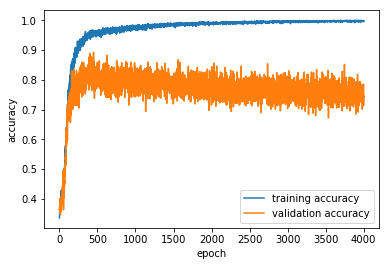

In [70]:
import matplotlib.pyplot as plt
epochs=list(range(1,num_epochs+1))
plt.figure()
# epochs=epochs[0::10]
# tr_losses=tr_losses[0::10]
# te_losses=te_losses[0::10]
plt.plot(epochs,tr_losses,label='training accuracy')
plt.plot(epochs,te_losses,label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [69]:
print("The highest validation accuracy is: ", max(te_losses))


print("At the same epoch, the training accuracy is: ", tr_losses[te_losses.index(max(te_losses))])

The highest validation accuracy is:  0.892578125
At the same epoch, the training accuracy is:  0.957421875


In [ ]:
print("The highest validation accuracy is: ", max(te_losses))


print("At the same epoch, the training accuracy is: ", tr_losses[te_losses.index(max(te_losses))])